# TSP - MTZ

In [21]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Formulation

$$
\begin{align}
    \text{min} \quad & \sum_{i, j \in A}d_{i, j} x_{i, j} \\
    \text{s.t.} \quad & \sum_{j \in V} x_{i, j} = \sum_{j \in V} x_{j, i} = 1 & \forall ~ i \in V\\
    & u_{i} + 1 \leq u_{j} + (|V| - 1) (1 - x_{i, j}) & \forall ~ i, j \in A: j \neq 0\\
    & x_{i, j} \in \left \{ 0, 1 \right \} & \forall ~ i, j \in A\\
\end{align}
$$

## Create instance

In [22]:
N = 30  # Number of points
np.random.seed(12)
coordinates = np.random.random((N, 2))
D = squareform(pdist(coordinates))

In [23]:
coordinates

array([[0.15416284, 0.7400497 ],
       [0.26331502, 0.53373939],
       [0.01457496, 0.91874701],
       [0.90071485, 0.03342143],
       [0.95694934, 0.13720932],
       [0.28382835, 0.60608318],
       [0.94422514, 0.85273554],
       [0.00225923, 0.52122603],
       [0.55203763, 0.48537741],
       [0.76813415, 0.16071675],
       [0.76456045, 0.0208098 ],
       [0.13521018, 0.11627302],
       [0.30989758, 0.67145265],
       [0.47122978, 0.8161683 ],
       [0.28958678, 0.73312598],
       [0.70262236, 0.32756948],
       [0.33464753, 0.97805808],
       [0.62458211, 0.95031352],
       [0.76747565, 0.82500925],
       [0.4066403 , 0.45130841],
       [0.40063163, 0.99513816],
       [0.17756418, 0.9625969 ],
       [0.41925027, 0.42405245],
       [0.46314887, 0.37372315],
       [0.4655081 , 0.03516826],
       [0.08427267, 0.7325207 ],
       [0.63619999, 0.02790779],
       [0.30017006, 0.22085252],
       [0.05501999, 0.52324607],
       [0.41636966, 0.04821875]])

In [24]:
D

array([[0.        , 0.23340552, 0.22675428, 1.02794135, 1.0039336 ,
        0.1864408 , 0.79805797, 0.26638038, 0.47240059, 0.84414894,
        0.94334049, 0.62406454, 0.17017305, 0.32607589, 0.13560082,
        0.68625634, 0.29870171, 0.51527193, 0.61916938, 0.38355755,
        0.3547069 , 0.22377418, 0.41246285, 0.47923638, 0.77058011,
        0.07029454, 0.8599453 , 0.53933646, 0.23839697, 0.73985301],
       [0.23340552, 0.        , 0.45836937, 0.8103065 , 0.79897726,
        0.07519588, 0.75192894, 0.26135552, 0.29274499, 0.62768484,
        0.71717763, 0.43667954, 0.14537839, 0.35070591, 0.20110996,
        0.4852803 , 0.45000825, 0.55140541, 0.58225087, 0.16533906,
        0.48139866, 0.43734651, 0.19064897, 0.25600541, 0.53801042,
        0.26752601, 0.62841771, 0.31504998, 0.20855917, 0.50907369],
       [0.22675428, 0.45836937, 0.        , 1.25261538, 1.22428372,
        0.41262096, 0.93199086, 0.39771171, 0.69041678, 1.06885982,
        1.16994421, 0.81149083, 0.3851882 , 0.

## pyomo model

In [25]:
# Initialize ConcreteModel
model = pyo.ConcreteModel()

In [26]:
# Sets nodes and arcs
model.V = pyo.Set(initialize=range(N))
model.A = pyo.Set(
    initialize=[(i, j) for i in range(N) for j in range(N) if i != j]
)

In [27]:
# Parameter pairwise distances
model.d = pyo.Param(model.A, initialize={(i, j): D[i, j] for i, j in model.A})

In [28]:
# Variables
model.x = pyo.Var(model.A, within=pyo.Binary)
model.u = pyo.Var(model.V, within=pyo.NonNegativeReals)

In [29]:
# Constraints
def arcs_in(model, i):
    return sum(model.x[:, i]) == 1.0


def arcs_out(model, i):
    return sum(model.x[i, :]) == 1.0


def precedence(model, i, j):
    if j != model.V.first():
        return model.u[i] + 1.0 <= model.u[j] + (len(model.V) - 1) * (1 - model.x[i,j])
    else:
        return pyo.Constraint.Skip


model.arcs_in = pyo.Constraint(model.V, rule=arcs_in)
model.arcs_out = pyo.Constraint(model.V, rule=arcs_out)
model.precedence = pyo.Constraint(model.A, rule=precedence)

In [30]:
# Objective
def obj(model):
    return sum(
        model.d[i,j] * model.x[i,j]
        for i,j in model.A
    )


model.obj = pyo.Objective(rule=obj, sense=pyo.minimize)

## Solve

In [31]:
solver = pyo.SolverFactory("appsi_highs")
res = solver.solve(model, tee=True)

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 3e+01]
  Cost   [3e-02, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
901 rows, 899 cols, 4234 nonzeros  0s
901 rows, 899 cols, 4234 nonzeros  0s

Solving MIP model with:
   901 rows
   899 cols (870 binary, 0 integer, 0 implied int., 29 continuous)
   4234 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   3.533653823     inf                  inf        0      0      0       110     0.0s
 C       0       0         0   0.00%   4.593316937     10.85090957       57.67%      378  

In [32]:
def find_tour(model):
    Q = [v for v in model.V]
    node = Q.pop(0)
    tour = [node]
    while len(Q) > 0:
        for other in Q:
            if np.isclose(model.x[node, other].value, 1, atol=1e-1):
                Q.remove(other)
                node = other
                tour.append(node)
    tour.append(tour[0])
    return tour

In [34]:
tour

array([ 0, 28,  7, 11, 27, 29, 24, 26, 10,  3,  4,  9, 15,  8, 23, 22, 19,
        1,  5, 12, 14, 13, 18,  6, 17, 20, 16, 21,  2, 25,  0])

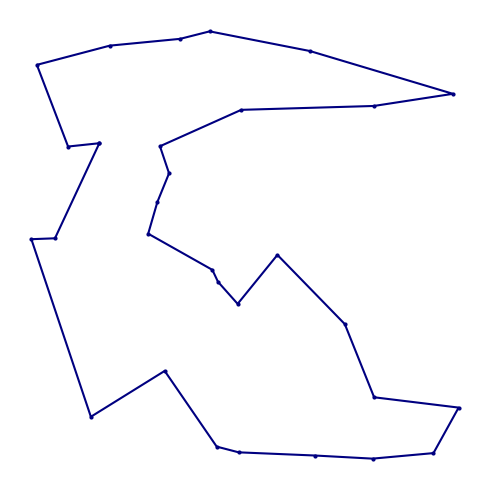

In [33]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)

tour = np.array(find_tour(model))
ax.scatter(coordinates[tour, 0], coordinates[tour, 1], color="navy", s=4)
ax.plot(coordinates[tour, 0], coordinates[tour, 1], color="navy")
ax.axis('off')

fig.tight_layout()
plt.show()